## Requirements


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install keras-rectified-adam
!pip install sounddevice
!sudo apt-get install libportaudio2

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=d30e9a2daf3b3343c1b968a43b8ef856c5aab6e05fa15cbdbe10919fce13f673
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (52.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-li

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
             raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sounddevice as sd
import IPython.display as ipd
import librosa.display
import multiprocessing
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
import os
import random
import warnings
os.environ['TF_KERAS'] = '1'
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from keras_radam import RAdam
%load_ext tensorboard
np.random.seed(999)
tf.random.set_seed(999)

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 739814899704787998, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6629724905138911965
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9340147400502708112
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12829993114923852650
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# Create Dataset

In [6]:
class MCVDataset:

    def __init__(self, basepath, *, val_dataset_size):
        self.basepath = basepath
        self.val_dataset_size = val_dataset_size

    def get_filenames(self, dataframe_name='train.csv'):
        mozilla_metadata = pd.read_csv(os.path.join(self.basepath, dataframe_name), sep=',')
        clean_files = mozilla_metadata['filename'].values
        np.random.shuffle(clean_files)
        print("Total number of training examples:", len(clean_files))
        return clean_files

    def get_train_val_filenames(self):
        clean_files = self.get_filenames(dataframe_name='train.csv')

        # resolve full path
        clean_files = [os.path.join(self.basepath, filename) for filename in clean_files]

        clean_files = clean_files[:-self.val_dataset_size]
        clean_val_files = clean_files[-self.val_dataset_size:]
        print("# of Training clean files:", len(clean_files))
        print("# of  Validation clean files:", len(clean_val_files))
        return clean_files, clean_val_files

In [7]:
class US8KDataset:
    def __init__(self, basepath, *, val_dataset_size, class_ids=None):
        self.basepath = basepath
        self.val_dataset_size = val_dataset_size
        self.class_ids = class_ids

    def get_filenames(self):
        urbansound_metadata = pd.read_csv(os.path.join(self.basepath, 'UrbanSound8K.csv'))

        # shuffle the dataframe
        urbansound_metadata.reindex(np.random.permutation(urbansound_metadata.index))

        return urbansound_metadata

    def _get_filenames_by_class_id(self, metadata):

        if self.class_ids is None:
            self.class_ids = np.unique(metadata['classID'].values)
            print("Number of classes:", self.class_ids)

        all_files = []
        file_counter = 0
        for c in self.class_ids:
            per_class_files = metadata[metadata['classID'] == c][['slice_file_name', 'fold']].values
            per_class_files = [os.path.join(self.basepath, 'fold' + str(file[1]), file[0]) for file in
                               per_class_files]
            print("Class c:", str(c), 'has:', len(per_class_files), 'files')
            file_counter += len(per_class_files)
            all_files.extend(per_class_files)

        assert len(all_files) == file_counter
        return all_files

    def get_train_val_filenames(self):
        urbansound_metadata = self.get_filenames()

        # folds from 0 to 9 are used for training
        urbansound_train = urbansound_metadata[urbansound_metadata.fold != 10]

        urbansound_train_filenames = self._get_filenames_by_class_id(urbansound_train)
        np.random.shuffle(urbansound_train_filenames)

        # separate noise files for train/validation
        urbansound_val = urbansound_train_filenames[-self.val_dataset_size:]
        urbansound_train = urbansound_train_filenames[:-self.val_dataset_size]
        print("Noise training:", len(urbansound_train))
        print("Noise validation:", len(urbansound_val))

        return urbansound_train, urbansound_val

In [8]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def get_tf_feature(noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase):
    noise_stft_mag_features = noise_stft_mag_features.astype(np.float32).tostring()
    clean_stft_magnitude = clean_stft_magnitude.astype(np.float32).tostring()
    noise_stft_phase = noise_stft_phase.astype(np.float32).tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'noise_stft_phase': _bytes_feature(noise_stft_phase),
        'noise_stft_mag_features': _bytes_feature(noise_stft_mag_features),
        'clean_stft_magnitude': _bytes_feature(clean_stft_magnitude)}))
    return example


def read_audio(filepath, sample_rate, normalize=True):
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize is True:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr


def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

In [9]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

In [10]:
class Dataset:
    def __init__(self, clean_filenames, noise_filenames, **config):
        self.clean_filenames = clean_filenames
        self.noise_filenames = noise_filenames
        self.sample_rate = config['fs']
        self.overlap = config['overlap']
        self.window_length = config['windowLength']
        self.audio_max_duration = config['audio_max_duration']

    def _sample_noise_filename(self):
        return np.random.choice(self.noise_filenames)

    def _remove_silent_frames(self, audio):
        trimed_audio = []
        indices = librosa.effects.split(audio, hop_length=self.overlap, top_db=20)

        for index in indices:
            trimed_audio.extend(audio[index[0]: index[1]])
        return np.array(trimed_audio)

    def _phase_aware_scaling(self, clean_spectral_magnitude, clean_phase, noise_phase):
        assert clean_phase.shape == noise_phase.shape, "Shapes must match."
        return clean_spectral_magnitude * np.cos(clean_phase - noise_phase)

    def get_noisy_audio(self, *, filename):
        return read_audio(filename, self.sample_rate)

    def _audio_random_crop(self, audio, duration):
        audio_duration_secs = librosa.core.get_duration(audio, self.sample_rate)

        # duration: length of the cropped audio in seconds
        if duration >= audio_duration_secs:
            return audio

        audio_duration_ms = math.floor(audio_duration_secs * self.sample_rate)
        duration_ms = math.floor(duration * self.sample_rate)
        idx = np.random.randint(0, audio_duration_ms - duration_ms)
        return audio[idx: idx + duration_ms]

    def _add_noise_to_clean_audio(self, clean_audio, noise_signal):
        if len(clean_audio) >= len(noise_signal):
            while len(clean_audio) >= len(noise_signal):
                noise_signal = np.append(noise_signal, noise_signal)

        ## Extract a noise segment from a random location in the noise file
        ind = np.random.randint(0, noise_signal.size - clean_audio.size)

        noiseSegment = noise_signal[ind: ind + clean_audio.size]

        speech_power = np.sum(clean_audio ** 2)
        noise_power = np.sum(noiseSegment ** 2)
        noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
        return noisyAudio

    def parallel_audio_processing(self, clean_filename):

        clean_audio, _ = read_audio(clean_filename, self.sample_rate)

        # remove silent frame from clean audio
        clean_audio = self._remove_silent_frames(clean_audio)

        noise_filename = self._sample_noise_filename()

        # read the noise filename
        noise_audio, sr = read_audio(noise_filename, self.sample_rate)

        # remove silent frame from noise audio
        noise_audio = self._remove_silent_frames(noise_audio)

        # sample random fixed-sized snippets of audio
        clean_audio = self._audio_random_crop(clean_audio, duration=self.audio_max_duration)

        # add noise to input image
        noiseInput = self._add_noise_to_clean_audio(clean_audio, noise_audio)

        # extract stft features from noisy audio
        noisy_input_fe = FeatureExtractor(noiseInput, windowLength=self.window_length, overlap=self.overlap, sample_rate=self.sample_rate)
        noise_spectrogram = noisy_input_fe.get_stft_spectrogram()
        # Or get the phase angle (in radians)
        noise_phase = np.angle(noise_spectrogram)

        # get the magnitude of the spectral
        noise_magnitude = np.abs(noise_spectrogram)

        # extract stft features from clean audio
        clean_audio_fe = FeatureExtractor(clean_audio, windowLength=self.window_length, overlap=self.overlap, sample_rate=self.sample_rate)
        clean_spectrogram = clean_audio_fe.get_stft_spectrogram()

        # get the clean phase
        clean_phase = np.angle(clean_spectrogram)

        # get the clean spectral magnitude
        clean_magnitude = np.abs(clean_spectrogram)

        clean_magnitude = self._phase_aware_scaling(clean_magnitude, clean_phase, noise_phase)

        scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
        noise_magnitude = scaler.fit_transform(noise_magnitude)
        clean_magnitude = scaler.transform(clean_magnitude)

        return noise_magnitude, clean_magnitude, noise_phase

    def create_tf_record(self, *, prefix, subset_size, parallel=True):
        counter = 0
        p = multiprocessing.Pool(multiprocessing.cpu_count())

        for i in range(0, len(self.clean_filenames), subset_size):

            tfrecord_filename = './tf_records/' + prefix + '_' + str(counter) + '.tfrecords'
            if os.path.isfile(tfrecord_filename):
                print(f"Skipping {tfrecord_filename}")
                counter += 1
                continue

            writer = tf.io.TFRecordWriter(tfrecord_filename)
            clean_filenames_sublist = self.clean_filenames[i:i + subset_size]

            print(f"Processing files from: {i} to {i + subset_size}")
            out = p.map(self.parallel_audio_processing, clean_filenames_sublist)
            print("This Subset is Completed")
            
            for o in out:
                noise_stft_magnitude = o[0]
                clean_stft_magnitude = o[1]
                noise_stft_phase = o[2]

                noise_stft_mag_features = prepare_input_features(noise_stft_magnitude, numSegments=8, numFeatures=129)

                noise_stft_mag_features = np.transpose(noise_stft_mag_features, (2, 0, 1))
                clean_stft_magnitude = np.transpose(clean_stft_magnitude, (1, 0))
                noise_stft_phase = np.transpose(noise_stft_phase, (1, 0))

                noise_stft_mag_features = np.expand_dims(noise_stft_mag_features, axis=3)
                clean_stft_magnitude = np.expand_dims(clean_stft_magnitude, axis=2)


                for x_, y_, p_ in zip(noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase):
                    y_ = np.expand_dims(y_, 2)
                    example = get_tf_feature(x_, y_, p_)
                    writer.write(example.SerializeToString())

            counter += 1
            writer.close()

In [11]:
%cd /content/drive/My Drive/Datasets/

warnings.filterwarnings(action='ignore')

mozilla_basepath = '/content/drive/My Drive/Datasets/CommonVoice'
urbansound_basepath = '/content/drive/My Drive/Datasets/UrbanSound8k'

mcv = MCVDataset(mozilla_basepath, val_dataset_size=1000)
clean_train_filenames, clean_val_filenames = mcv.get_train_val_filenames()
us8K = US8KDataset(urbansound_basepath, val_dataset_size=200)
noise_train_filenames, noise_val_filenames = us8K.get_train_val_filenames()

windowLength = 256
config = {'windowLength': windowLength,
          'overlap': round(0.25 * windowLength),
          'fs': 16000,
          'audio_max_duration': 0.8}
          
val_dataset = Dataset(clean_val_filenames, noise_val_filenames, **config)
val_dataset.create_tf_record(prefix='val', subset_size=2000)

train_dataset = Dataset(clean_train_filenames, noise_train_filenames, **config)
train_dataset.create_tf_record(prefix='train', subset_size=1000)

/content/drive/My Drive/Datasets
Total number of training examples: 5000
# of Training clean files: 4000
# of  Validation clean files: 1000
Number of classes: [0 1 2 3 4 5 6 7 8 9]
Class c: 0 has: 900 files
Class c: 1 has: 396 files
Class c: 2 has: 900 files
Class c: 3 has: 900 files
Class c: 4 has: 900 files
Class c: 5 has: 907 files
Class c: 6 has: 342 files
Class c: 7 has: 904 files
Class c: 8 has: 846 files
Class c: 9 has: 900 files
Noise training: 7695
Noise validation: 200
Skipping ./tf_records/val_0.tfrecords
Skipping ./tf_records/train_0.tfrecords
Skipping ./tf_records/train_1.tfrecords
Skipping ./tf_records/train_2.tfrecords
Skipping ./tf_records/train_3.tfrecords


# Prepare Input Features

In [12]:
train_tfrecords_filenames = glob.glob('/content/drive/My Drive/Datasets/tf_records/train_*')
np.random.shuffle(train_tfrecords_filenames)
train_tfrecords_filenames = list(train_tfrecords_filenames)
print(train_tfrecords_filenames)
val_tfrecords_filenames = glob.glob('/content/drive/My Drive/Datasets/tf_records/val_*')

['/content/drive/My Drive/Datasets/tf_records/train_2.tfrecords', '/content/drive/My Drive/Datasets/tf_records/train_3.tfrecords', '/content/drive/My Drive/Datasets/tf_records/train_1.tfrecords', '/content/drive/My Drive/Datasets/tf_records/train_0.tfrecords']


In [13]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [14]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

In [15]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512+256)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

# Model architecture

In [16]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential
def model_architecture(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)

  model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [17]:
model = model_architecture(l2_strength=0)
model.summary()
# model.save_weights('/content/drive/My Drive/Datasets/denoiser_cnn_log_mel_generator.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
______________________________________________________________________________________________

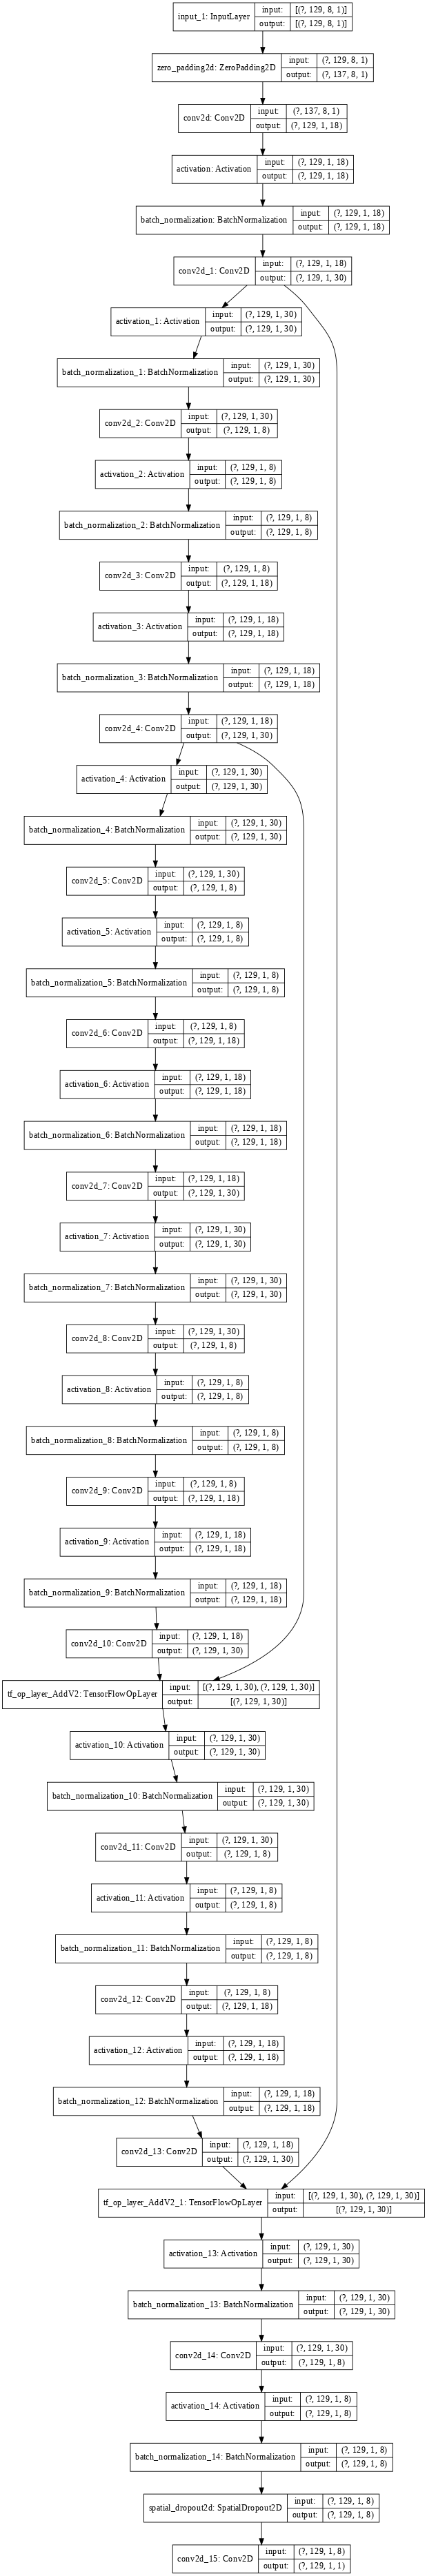

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
%tensorboard --logdir logs

# Training

In [19]:
model.load_weights('/content/drive/My Drive/Datasets/denoiser_cnn_log_mel_generator.h5')
baseline_val_loss = model.evaluate(test_dataset)[0]
print(baseline_val_loss)

393/393 [==============================] - 24s 60ms/step - loss: 0.1470 - rmse: 0.3834
0.146959587931633


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=baseline_val_loss)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Datasets/denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=600,
         validation_data=test_dataset,
         epochs=200,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

In [20]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
   model.save('/content/drive/My Drive/Datasets/denoiser_cnn_log_mel_generator.h5')

393/393 [==============================] - 18s 47ms/step - loss: 0.1470 - rmse: 0.3834


In [ ]:
%tensorboard --logdir logs

# Testing

In [21]:
model.load_weights('/content/drive/My Drive/Datasets/denoiser_cnn_log_mel_generator.h5')
FIG_SIZE=(10,5)
def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))

def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): 
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

Min: -0.3333333 Max: 0.29656973


Text(0.5, 1.0, 'sample-002642.mp3')

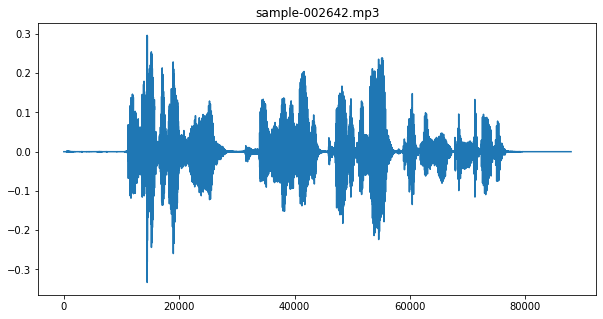

In [22]:
clean_test_filename=random.choice(os.listdir("/content/drive/My Drive/Datasets/CommonVoice/cv-valid-test"))

cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'cv-valid-test', clean_test_filename), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
play(cleanAudio, sr) 

plt.figure(figsize=FIG_SIZE)  
plt.plot(cleanAudio)
plt.title(clean_test_filename)

Min: -0.33333334 Max: 0.21030058


Text(0.5, 1.0, '99192-4-0-52.wav')

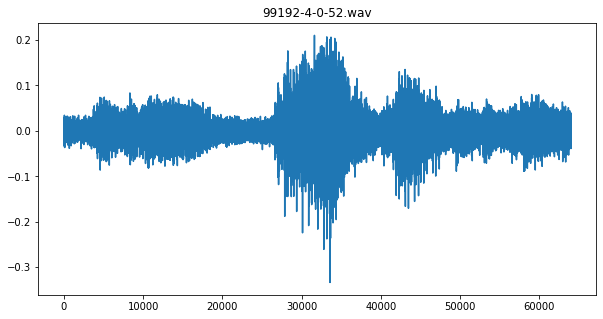

In [23]:
noise_test_filename=random.choice(os.listdir("/content/drive/My Drive/Datasets/UrbanSound8k/fold10"))

noiseAudio, sr = read_audio(os.path.join(urbansound_basepath, 'fold10', noise_test_filename), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
play(noiseAudio, sr) 

plt.figure(figsize=FIG_SIZE)  
plt.plot(noiseAudio)
plt.title(noise_test_filename)

Min: -0.33714288 Max: 0.28425303


Text(0.5, 1.0, 'Noisy Audio')

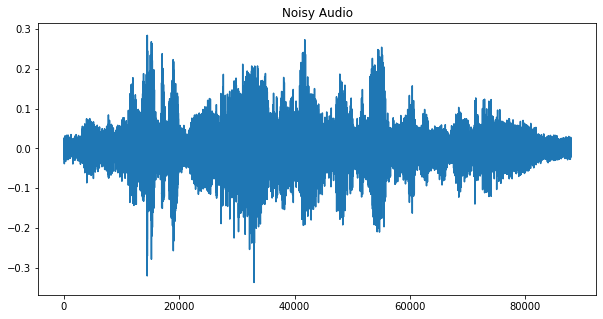

In [24]:
create_test=Dataset(clean_test_filename, noise_test_filename, **config)
noisyAudio = create_test._add_noise_to_clean_audio(cleanAudio, noiseAudio)
print("Min:", np.min(noisyAudio),"Max:",np.max(noisyAudio))
play(noisyAudio, sr) 

plt.figure(figsize=FIG_SIZE)  
plt.plot(noisyAudio)
plt.title("Noisy Audio")

In [25]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 0.0 Max: 10.137464


In [26]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()


noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 1375)


In [27]:
predictors = prepare_input_features(noise_stft_features,numSegments,numFeatures)
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print(predictors.shape)

(1375, 129, 8, 1)


In [28]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(1375, 129, 1, 1)


Min: -0.23150681 Max: 0.2341169


Text(0.5, 1.0, 'Denoised Audio')

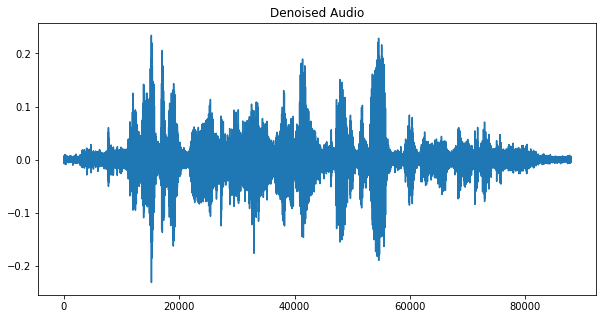

In [29]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
play(denoisedAudioFullyConvolutional, fs)
plt.figure(figsize=FIG_SIZE)
plt.plot(denoisedAudioFullyConvolutional)
plt.title("Denoised Audio")

In [30]:
SNR=SDR(denoisedAudioFullyConvolutional,cleanAudio)
print(SNR)

2.4585907


# Feeding output again with same model 

In [36]:
def Revaluation(noisyAudio,n):
 if n>0:
     noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
     noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()
     noisyPhase = np.angle(noise_stft_features)
     noise_stft_features = np.abs(noise_stft_features)
     mean = np.mean(noise_stft_features)
     std = np.std(noise_stft_features)
     noise_stft_features = (noise_stft_features - mean) / std
     predictors = prepare_input_features(noise_stft_features,numSegments,numFeatures)
     predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
     predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
     STFTFullyConvolutional = model.predict(predictors)
     
     denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
     Revaluation(denoisedAudioFullyConvolutional,n-1)
 else :
     print("Min:", np.min(noisyAudio),"Max:",np.max(noisyAudio))
     play(noisyAudio, fs)
     plt.figure(figsize=FIG_SIZE)
     plt.plot(noisyAudio)
     plt.title("Denoised Audio")
     SNR=SDR(noisyAudio,cleanAudio)
     print(SNR)

Min: -0.23150681 Max: 0.2341169


2.4585907


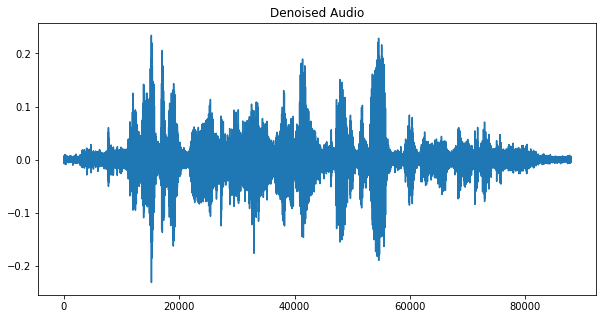

In [38]:
Revaluation(denoisedAudioFullyConvolutional,0)